In [192]:
%cd vanhateren_iml

[Errno 2] No such file or directory: 'vanhateren_iml'
/Users/peterbaumbacher/Dropbox/Cal/2018 - Fall/vs265/proj/ICA_Comparison/vanhateren_iml


In [297]:
import numpy as np
import array 
import sklearn
from skimage import color
import scipy as sp
from sklearn.feature_extraction import image
from sklearn.decomposition import FastICA, PCA
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

# patch_size  = 8
# p_per_image = 10000
# n_images    = 9
patch_size = 16
p_per_image = 200
n_images = 200
r_dim = 64

In [233]:
def plotDataTiled(data, title="", prevFig=None):
  """
    Create a matplotlib plot that displays data as subplots
    Inputs:
      data [np.ndarray] 2-D array of dims (numPixels, batchSize)
        It is assumed that numPixels has an even square root
      title [str] optional string to set as the figure title
  """
  if len(data.shape) == 2:
    (numPixels, batchSize) = data.shape
  elif len(data.shape) == 1:
    numPixels = data.shape
    batchSize = 1
    data = data[:,None]
  else:
    assert 0, ("len(data.shape) should = 2 or 1")
  assert numPixels%np.sqrt(numPixels) == 0, (
        "data.shape[0]  must have an even square root")
  pixelEdgeSize = int(np.sqrt(numPixels))
  subplotEdgeSize = int(np.ceil(np.sqrt(batchSize)))
  if prevFig is not None:
    (fig, subAxes, axisImage) = prevFig
  else:
    fig, subAxes = plt.subplots(nrows=subplotEdgeSize, ncols=subplotEdgeSize)
    axisImage = [None]*len(fig.axes)
  for axisIndex, axis in enumerate(fig.axes):
    if axisIndex < batchSize:
      image = data[:,axisIndex].reshape(pixelEdgeSize, pixelEdgeSize)
      if prevFig is not None:
        axisImage[axisIndex].set_data(image)
      else:
        axisImage[axisIndex] = axis.imshow(image, cmap="Greys",
          interpolation="nearest")
        axis.tick_params(
          axis="both",
          bottom="off",
          top="off",
          left="off",
          right="off")
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    else:
      for spine in axis.spines.values():
        spine.set_visible(False)
      axis.tick_params(
        axis="both",
        bottom="off",
        top="off",
        left="off",
        right="off")
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
  fig.suptitle(title)
  if prevFig is not None:
    fig.canvas.draw()
  else:
    fig.show()
  return (fig, subAxes, axisImage)

def plotImg(img):
    # img = (img - img.min()) / abs(img.max() - img.min())
    plt.figure()
    plt.imshow(img, vmin=img.min(), vmax=img.max(), cmap='gray')

[1599 1542 1579 1562 1579 1562 1562 1599 1562 1579 1562 1542 1579 1562 1562
 1562 1579 1524 1562 1579 1562 1562 1562 1619 1562 1579 1562 1579 1599 1562
 1579 1562 1599 1562 1579 1579 1562 1599 1562 1579 1579 1579 1562 1579 1619
 1542 1599 1579 1599 1562]


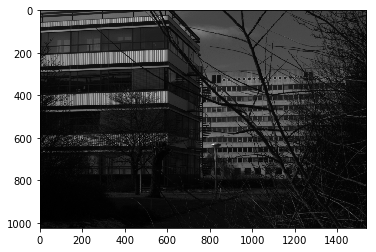

In [285]:
img_name = 'imk00005.iml'
with open(img_name, 'rb') as handle:
    s = handle.read()
arr = array.array('H', s)
arr.byteswap()
img = np.array(arr, dtype='uint16')
print(img[1000:1050])
img = img / np.max(img)
img = (img - np.mean(img)) / np.std(img)
img = img.reshape(1024, 1536)
plotImg(img)

In [286]:
def load_img(img_name):
    with open(img_name, 'rb') as handle:
        s = handle.read()
    arr = array.array('H', s)
    arr.byteswap()
    img = np.array(arr, dtype='uint16')
    #img = img / np.max(img)
    img = (img - np.mean(img)) / np.std(img)
    img = img.reshape(1024, 1536)
    return img

In [287]:
def load_patches(n_images, p_per_img, patch_size):
    """
    Returns a set of patches. These aren't whitened or whatever so yeah.
    """
    fmt_string = 'imk{0:05d}.iml'
    max_img_num = 4000
    
    patches = []
    for _ in range(n_images):
        while True:
            try:
                img_num = np.random.randint(1, max_img_num)
                filename = fmt_string.format(img_num)
        
                with open(filename, 'rb') as handle:
                    s = handle.read()
                break
            except:
                continue
        arr   = array.array('H', s)
        arr.byteswap()
        img   = np.array(arr, dtype='uint16').reshape(1024 * 1536)
        img   = (img - np.mean(img)) / np.std(img)
        img = img.reshape(1024, 1536)
        
        patch = image.extract_patches_2d(img, [patch_size, patch_size], max_patches = p_per_image)
        patches.append(patch)
        
    patches = np.array(patches)
    patches = np.reshape(patches, [n_images*p_per_image, patch_size * patch_size])
    return patches

In [288]:
def denoise_img(img, pca, W_ortho, nonlinearity):
    """
    Denoises an img using ica. Assumes that img has already been 0-meaned, etc.
    """
    img_r, img_c = img.shape
    img_patches = image.extract_patches_2d(img, (patch_size, patch_size))
    patch_count = img_patches.shape[0]
    img_patches = img_patches.reshape(patch_count, patch_size**2)
    #print(img_patches[3])
    
    # pca = PCA(n_components=r_dim, whiten=True)
    whitened_patches = pca.transform(img_patches)
    #print(whitened_patches[3])
    components = whitened_patches @ W_ortho.T
    print(components[3])
    #shrunk_components = nonlinearity(components)
    shrunk_components = np.apply_along_axis(nonlinearity, 1, components)
    print(shrunk_components[3])
    denoised_patches = pca.inverse_transform(shrunk_components @ np.linalg.inv(W_ortho.T))
    #print(denoised_patches[3])
    
    # Reconstruct the image:
    denoised_patches = denoised_patches.reshape(patch_count, patch_size, patch_size)
    return image.reconstruct_from_patches_2d(denoised_patches, (img_r, img_c))

In [289]:
patches = load_patches(n_images, p_per_image, patch_size)

print(patches.shape)
pca = PCA(n_components=r_dim, whiten=True)
patches = pca.fit_transform(patches)
print(patches.shape)

(40000, 256)
(40000, 64)


(40000, 64)
(64, 64)
[ 0.00730878 -0.00417002 -0.00188298 -0.00454589  0.00682344 -0.00226162
 -0.0045782  -0.0070082   0.00161335 -0.00838939  0.00428784 -0.00366913
  0.00257686 -0.00383068 -0.00412505 -0.0056751   0.00696514 -0.00084263
  0.00244926  0.0088886  -0.00200969 -0.00954089 -0.00502873 -0.00133557
  0.00075194  0.00068658 -0.0012337   0.00418296  0.00040592 -0.00379689
 -0.00890559  0.00349917 -0.00056039  0.0038503   0.00696361 -0.00313503
  0.00834582  0.00300678  0.00198528 -0.00399016  0.00080201  0.00153408
 -0.00512591 -0.0105829   0.00465092  0.01188486 -0.012617   -0.00126941
  0.00482432  0.00022511  0.00815466 -0.01235272  0.00660199 -0.00904847
 -0.0089766   0.00267643  0.00044357  0.00057915 -0.00277136 -0.00464565
 -0.0142335  -0.00687657 -0.00731791  0.00325102]
[ 1.46173767 -0.83399353 -0.37659147 -0.90916603  1.36467119 -0.4523187
 -0.91562891 -1.40162313  0.32266695 -1.67785747  0.85755751 -0.73381623
  0.51536615 -0.7661264  -0.82500008 -1.13500563  1.39

/Users/peterbaumbacher/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


(<matplotlib.figure.Figure at 0x17e8b1518>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x17f37a390>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x179a96eb8>]], dtype=object),
  <matplotlib.image.AxesImage at 0x17aeb5898>])

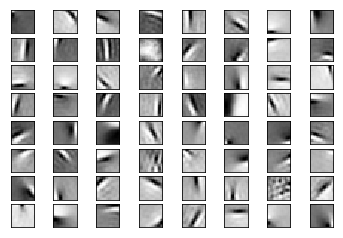

In [290]:
# Use Fast ICA to find independent components of image patches
def tanh_nonlin(x):
    return np.tanh(x), (1/np.cosh(x))**2

ica = FastICA(n_components = r_dim, max_iter=500)
ica.fit_transform(patches)
print(transformed_patches.shape)
W   = ica.components_
print(W.shape)

W_vis = W
W_vis = W @ np.real( np.linalg.inv(sp.linalg.sqrtm(W.T @ W)) )
W_ortho = W @ np.real( np.linalg.inv(sp.linalg.sqrtm(W.T @ W)) )
transformed_patches = patches @ W_ortho.T

W_vis = pca.inverse_transform(W_vis)
print(ica.transform(patches)[10000])
print(transformed_patches[10000])

Bs = []
As = []
for i in range(r_dim):
    kde = KernelDensity()
    activations = transformed_patches[:,i].reshape((-1, 1))
    #print(activations.shape)
    E_abs = np.mean(np.abs(activations))
    E_square = np.mean(activations ** 2)
    kde.fit(activations)
    p_s_zero = np.exp(kde.score(np.array([0]).reshape(1,1)))
    
    b = (2 * p_s_zero * E_square - E_abs) / (E_square - E_abs**2)
    b = np.clip(b, 0, np.sqrt(2/E_square))
    a = (1 - E_abs * b) / E_square
    a = np.clip(a, 0, 1/E_square)
    
    Bs.append(b)
    As.append(a)
Bs = np.array(Bs)
As = np.array(As)
print(Bs)
print(As)

plotDataTiled(W_vis.T)
# for i in range(8):
#     for j in range(8):
#         ax = axs[i, j]
#         ax.imshow(W_vis[i*8 + j], cmap = 'Greys')
#         ax.tick_params(
#           axis="both",
#           bottom="off",
#           top="off",
#           left="off",
#           right="off")
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)


(array([  1.00000000e+00,   1.00000000e+00,   4.00000000e+00,
          2.00000000e+00,   3.00000000e+00,   3.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   3.00000000e+00,
          6.00000000e+00,   7.00000000e+00,   4.00000000e+00,
          1.20000000e+01,   1.00000000e+01,   6.00000000e+00,
          8.00000000e+00,   1.30000000e+01,   7.00000000e+00,
          6.00000000e+00,   7.00000000e+00,   1.00000000e+01,
          1.30000000e+01,   1.60000000e+01,   2.20000000e+01,
          2.00000000e+01,   2.50000000e+01,   2.20000000e+01,
          4.20000000e+01,   3.40000000e+01,   3.50000000e+01,
          4.10000000e+01,   4.50000000e+01,   5.60000000e+01,
          5.20000000e+01,   6.60000000e+01,   7.00000000e+01,
          7.10000000e+01,   8.30000000e+01,   1.07000000e+02,
          1.11000000e+02,   1.22000000e+02,   1.56000000e+02,
          1.60000000e+02,   1.76000000e+02,   2.39000000e+02,
          3.13000000e+02,   3.79000000e+02,   5.10000000e+02,
        

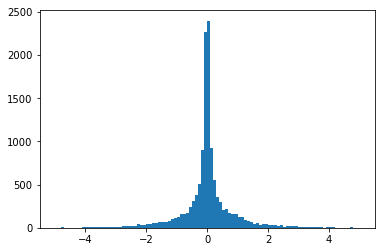

In [291]:
plt.hist(transformed_patches[10100:10300].flatten(), bins=100, range=(-5,5))

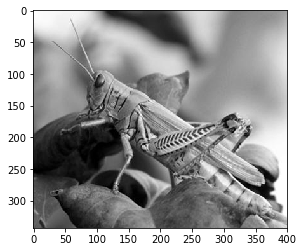

In [299]:

plotImg(img)

MSE: 0.0898306978531
[ -5.91827731e-01   1.05797064e-01   3.34558609e-01  -1.07265847e+00
  -3.77785602e-01  -4.17144472e-02  -2.43862319e-01  -5.34060623e-01
   4.53475256e-01   8.31891771e-02   1.11682590e+00  -2.49115297e+00
   2.17208316e-01   2.96335864e-01  -1.82136557e-01  -4.67869657e-01
   4.04553963e-01   2.60058300e-01  -1.06234244e+00   1.23824415e+00
   2.77978502e-01   3.34371608e-01   4.17579402e-02  -5.64447981e-01
   3.50395628e-01  -6.31333345e-01   5.59292436e-01   5.03642821e-01
  -3.58167917e-01  -2.15278331e-02  -1.74030013e-01   2.21425650e-01
   4.59506684e-01  -3.85050768e-01  -2.78333457e-01  -1.75136223e-01
   2.27115700e-02  -1.49904510e-01   1.42215696e-01  -6.89771355e-04
   2.50641006e-01   9.36582644e-02   1.80245449e-01   3.00833933e-01
   1.16865701e+00  -7.03492316e-02  -1.26818868e+00   4.78125371e-01
   7.79833100e-01  -1.55718691e-01  -1.77540178e-01   6.02881052e-01
  -1.86353824e-01   2.57359885e-01  -4.05173908e-01   1.02581310e+00
   1.94099497

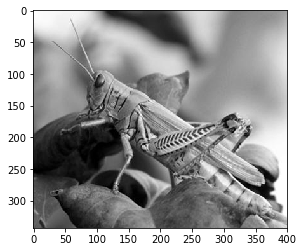

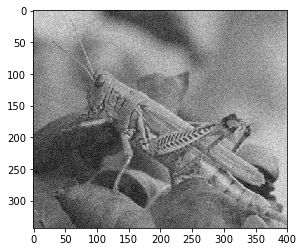

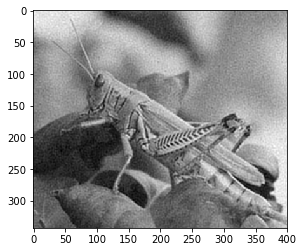

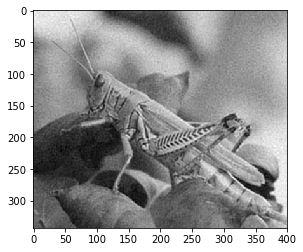

In [309]:
#img = load_img('imk00204.iml')
img = plt.imread("../grasshopper.jpg", format="jpeg")
img = color.rgb2gray(img)
img = (img - np.mean(img)) / np.std(img)
plotImg(img)
# noise_img = np.random.normal(scale=0.8,size=(1024, 1536)) + img
noise_img = np.random.normal(scale=0.3,size=(343, 400)) + img
sigma_squared = 0.3
print("MSE: " + str(np.mean((img-noise_img)**2)))
plotImg(noise_img)
#b_sigma_2 = 0.005
nonlinearity = lambda u : np.sign(u) * np.maximum(0, np.abs(u) - sigma_squared*Bs) / (1 + sigma_squared*As)
d_img = denoise_img(noise_img, pca, W_ortho, nonlinearity)
print("MSE: " + str(np.mean((img-d_img)**2)))
plotImg(d_img)
sigma_squared = np.sqrt(sigma_squared)
nonlinearity = lambda u : np.sign(u) * np.maximum(0, np.abs(u) - sigma_squared*Bs) / (1 + sigma_squared*As)
d_img = denoise_img(noise_img, pca, W_ortho, nonlinearity)
print("MSE: " + str(np.mean((img-d_img)**2)))
plotImg(d_img)

In [197]:
A = np.random.randn(40,9999)
B = np.random.randn(40,1)
print((A * B).shape)

(40, 9999)
